# Paper Figures
Jupyter notebook for generating figures for ECC paper

In [49]:
from util.trajectories import * 
from util.simplicial_paths import *
from util.guided_ot import augmented_dijkstra, find_intermediate_path, get_path_cost, bhattacharya, make_analytical_func, r2complex, make_proj_dict
from util.alg_perf import dijkstra_tree
from util.pqdict import pqdict
from itertools import combinations

# Trajectories
Projection progression and harmonic bases for methods section 

In [ ]:
n_side, point_gen_mode = 20, 0

r1, r2 = 0.6, 0.3
n_holes = 2
angle = 2 * np.pi / n_holes
phase = np.pi/4
hole_locs = [(r1 * np.cos(angle * i + phase), r1 * np.sin(angle * i + phase)) for i in range(n_holes)]
hole_locs += np.array([0.0, 0.05])

# Initialize Simplicial Complex (SC)
pts = generate_pts(point_gen_mode, n_side)
SC = SimplicialComplex(pts, True)
n_side, point_gen_mode = 20, 0
start, end = 0, len(SC.node_vec)-1

all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.make_holes(hole_locs, r2)
plt.figure(figsize=(6,6))
SC.plot()


In [ ]:
num_paths, num_nodes, visit_weight = 3, 1, 0.1

coords1 = [[(-1,-1), (-0.8, 0), (0, .8), (1,1)]] # above both
coords2 = [[(-1,-1), (-0.8, 0), (0.8, 0), (1,1)]] # above, below
coords3 = [[(-1,-1), (0, -0.8), (0, 0.8), (1,1)]] # below, above
coords4 = [[(-1,-1), (0, -0.8,), (0.8, 0), (1,1)]] # below both
coords5 = [[(-1,-1), (1,-1), (0.8, 0.8), (0, 0.8), (0,-1), (-1,-1), (-1,1), (1,1)]] # loopty

class_coords = coords1 + coords2 + coords3 + coords4 # + coords5
class_names = ["above both", "above then below", "below then above", "below both", "loopy"]

holder = Trajectory_Holder(SC, class_coords, num_paths, class_names, colors, num_nodes, visit_weight)

In [ ]:
holder = Trajectory_Holder(SC, class_coords, num_paths, class_names, colors, num_nodes, visit_weight)
holder.plot_paths(figsize=(4,4), overlay=False)
plt.show()

In [ ]:
holder = Trajectory_Holder(SC, class_coords, num_paths, class_names, colors, num_nodes, visit_weight)
holder.plot_paths(figsize=(5,5), overlay=True)
plt.show()

In [ ]:
holder.plot_projections(arrow_width=0.008, figsize=(6,6), star_size = 300,  origin_size = 50)
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
plt.xlabel("Projection of path onto $h_1$", labelpad=5, fontdict=font)
plt.ylabel("Projection of path onto $h_2$", labelpad=5, fontdict=font)
plt.title("Path Projections in Distinct Homology Classes", pad=20, fontdict=font)
plt.savefig(fname="projection_progression.eps", format='eps')
plt.show()

# Harmonic Bases

In [2]:
def plot_bases(SC, extra, font, figsize=(5,5), arrowmult=7, node_size=5):
    node_pos = {i:SC.nodes[i] for i in (np.where(SC.node_vec == 1)[0])}
    num_bases = SC.H_extra.shape[0] if extra else SC.H.shape[0]
    for i in range(num_bases):
        harm_vec = SC.H_extra[i,:]
        harm_vec_sign = np.sign(harm_vec)
        harm_vec_weight = np.abs(harm_vec)
        GG = nx.DiGraph()
        G_oriented = nx.DiGraph()
        j = 0
        for k, edge in enumerate(SC.edges):
            if not SC.edge_vec[k]:
                continue
            sign, weight = harm_vec_sign[j], harm_vec_weight[j] * 10
            oriented_edge = (edge[0], edge[1]) if (sign > 0) else (edge[1], edge[0])
            G_oriented.add_edge(oriented_edge[0], oriented_edge[1], weight=weight)
            GG.add_edge(edge[0], edge[1], weight=weight)
            j += 1

        oriented_weights = [G_oriented[u][v]['weight'] for u,v in G_oriented.edges]
        plt.figure(figsize=figsize)
        nx.draw(G_oriented, pos=node_pos, node_size=node_size, node_color='gray', width=oriented_weights, edge_color='black', arrows=True, arrowstyle='-|>', arrowsize=[arrowmult * i for i in oriented_weights])
        plt.title(f"Harmonic Basis Vector $h_{i+1}$", fontdict=font)
        plt.show()

def plot_outputs(SC, paths, colors=['firebrick', 'dodgerblue', 'darkorange', 'fuchsia', 'darkkhaki', 'aqua'], labels=None, figsize=(5,5), plot_paths=True, plot_proj=True, plot_save=None):
    num_holes = paths[0].edge_projections[-1].shape[0]
    hole_list = np.arange(num_holes)
    axes_to_plot = list(combinations(hole_list, 2))
    holder = Trajectory_Holder(SC)

    for i, path_i in enumerate(paths):
        path_class = Trajectory_Class(SC)
        path_class.add_path(path_i)
        label_i = None if labels is None else labels[i]
        holder.add_class(path_class, None, class_color=colors[i%len(colors)], class_name=label_i)

    if plot_paths:
        holder.plot_paths(True, figsize=figsize, fname=plot_save)

    if plot_proj:
        for ax in axes_to_plot:
            holder.plot_projections(proj_axes=ax, figsize=figsize)

    return holder

#arrowmult, nodesize = 7, 3
#plot_bases(SC, False, font, (5,5), arrowmult, nodesize)

# Results (Varying alpha)

In [3]:
n_side, point_gen_mode = 20, 0

r1, r2 = 0.7, 0.25
n_holes = 4
angle = 2 * np.pi / n_holes
phase = np.pi/4
hole_locs = [(r1 * np.cos(angle * i + phase), r1 * np.sin(angle * i + phase)) for i in range(n_holes)]

# Initialize Simplicial Complex (SC)
pts = generate_pts(point_gen_mode, n_side)
SC = SimplicialComplex(pts, True)
n_side, point_gen_mode = 20, 0
start, end = 0, len(SC.node_vec)-1

all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.make_holes(hole_locs, r2)
#plt.figure(figsize=(6,6))
#SC.plot()

In [4]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

#plot_bases(SC, False, font, (5,5))

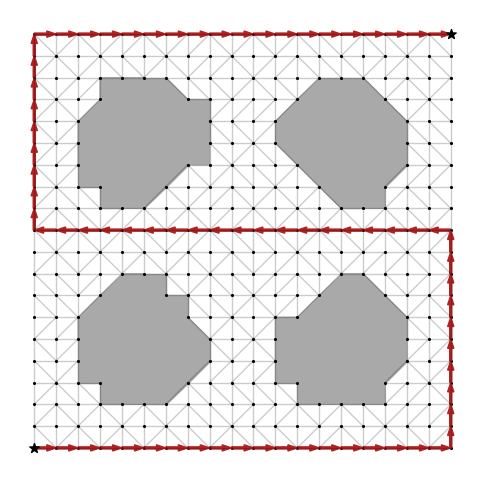

In [5]:
coords = np.array([(-1,-1), (1,-1), (1,0), (-1,0), (-1, 1), (1,1)])
ref_path, ref_path_class, path_proj, _ = path_from_coords(SC, coords, 'firebrick', True)
start, end = ref_path.nodes[0], ref_path.nodes[-1]
ref_class = Trajectory_Class(SC, False)
ref_class.add_path(ref_path)

In [6]:
alphas = [2] #[0, 0.5, 1, 2]
paths = []
ref_proj = ref_path.edge_projections[-1]

for alpha in alphas:
    path, _, _, _, _ = augmented_dijkstra(SC, start, end, ref_proj, alpha, False, 0)
    paths.append(path)

In [46]:
def rollout_rec(SC, partial, curr_node, ref_path, alpha, start, end, depth, max_depth):
    if curr_node == end:
        path = Trajectory(SC, partial, 0)
        cost = get_path_cost(path, ref_path, alpha)
        return path, cost

    elif depth == max_depth:
        path = find_intermediate_path(SC, partial, ref_path, end, alpha)
        cost = get_path_cost(path, ref_path, alpha)
        return path, cost

    path_options = []
    costs = []
    nodes = []
    
    for v in SC.graph.neighbors(curr_node):
        path_v, cost_path_v = rollout_rec(SC, partial + [v], v, ref_path, alpha, start, end, depth+1, max_depth)
        path_options += [path_v]
        costs += [cost_path_v]
        nodes += [v]
        #print("cost:", cost_path_v, "curr next:", (curr_node, v),  "path:", path_v)

    costs, nodes = np.array(costs), np.array(nodes, dtype=int)
    #print([(costs[i], nodes[i]) for i in range(len(costs))])
    cost_diffs = np.round(costs - np.min(costs), 10)
    #print(cost_diffs)
    equal_node_idx = np.where(cost_diffs == 0)[0]
    nodes_to_consider = nodes[equal_node_idx]
    #print("equal nodes", [nodes[i] for i in equal_node_idx])
    if len(nodes_to_consider) > 1:
        best_node = np.min(nodes_to_consider)
    else:
        best_node = nodes_to_consider[0]
    best_node_idx = int(np.where(nodes == best_node)[0])

    #best_idx = [i for (i,v) in enumerate(nodes) if (int(v) == int(best_node_idx))][0]
    #print(nodes, best_node_idx, best_idx)
    best_cost, best_path = costs[best_node_idx], path_options[best_node_idx]

    return best_path, best_cost


def k_rollout(SC, ref_path, alpha, max_depth):
    start, end = ref_path.nodes[0], ref_path.nodes[-1]
    vk = start
    path = [start]

    ref_class = Trajectory_Class(SC)
    ref_class.add_path(ref_path)
    best_costs, best_paths = [], []

    k=0
    # print('vk =', vk)
    while vk != end:
        path_vk, cost_vk = rollout_rec(SC, path, vk, ref_path, alpha, start, end, 0, max_depth)
        vk = path_vk.nodes[k+1]
        print("vk =", vk, "cost(vk) =", cost_vk)
        path += [vk]
        best_paths += [path_vk]
        best_costs += [cost_vk]
        k+=1 
        print("-"*200)
        #print('vk =', vk)

    return Trajectory(SC, path, 0), best_costs, best_paths

In [47]:
path_k1, _, _ = k_rollout(SC, ref_path, alphas[-1], 1)

vk = 1 cost(vk) = 6.7156831445498515
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
vk = 2 cost(vk) = 6.7156831445498515
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
vk = 3 cost(vk) = 6.7156831445498515
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
vk = 4 cost(vk) = 6.7156831445498515
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
vk = 5 cost(vk) = 6.7156831445498515
-----------

In [48]:
path_k2, _, _ = k_rollout(SC, ref_path, alphas[-1], 2)

vk = 1 cost(vk) = 6.7156831445498515
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
vk = 22 cost(vk) = 6.654021414273351
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
vk = 43 cost(vk) = 6.654021414273351
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
vk = 44 cost(vk) = 6.654021414273351
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
vk = 45 cost(vk) = 6.654021414273351
-----------

In [50]:
zeros = make_analytical_func(2, len(hole_locs))
poles = r2complex(np.array(hole_locs))
proj_dict = make_proj_dict(SC, zeros, poles)
start, end = ref_path.nodes[0], ref_path.nodes[-1]
path, other_paths = bhattacharya(SC, ref_path, start, end, proj_dict, others=True)

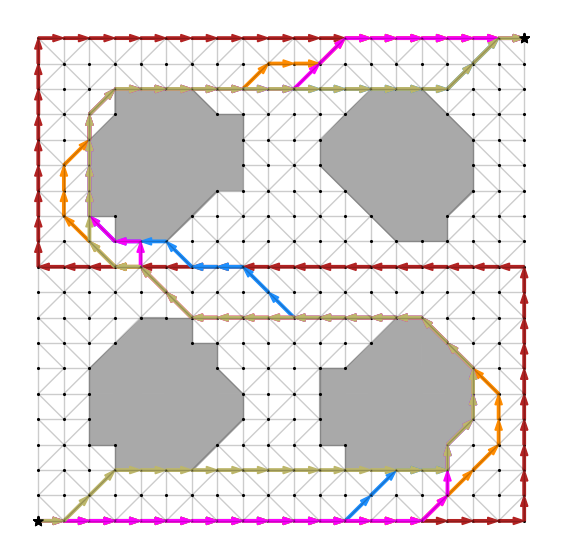

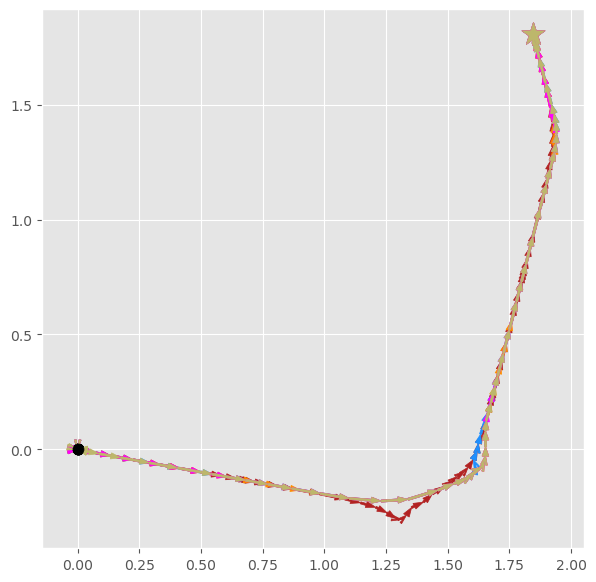

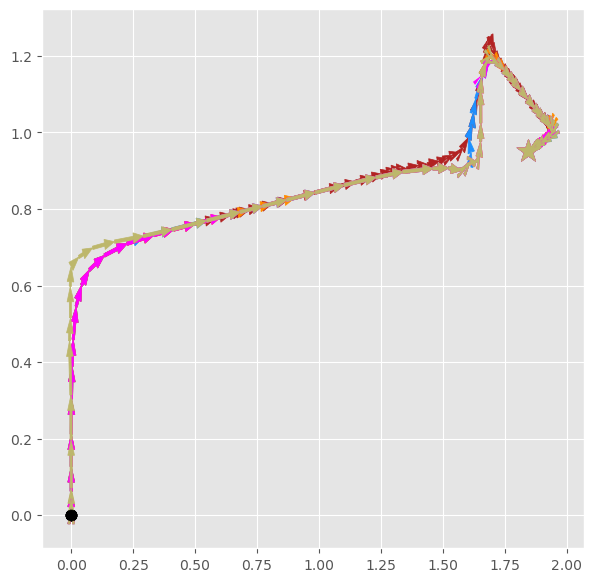

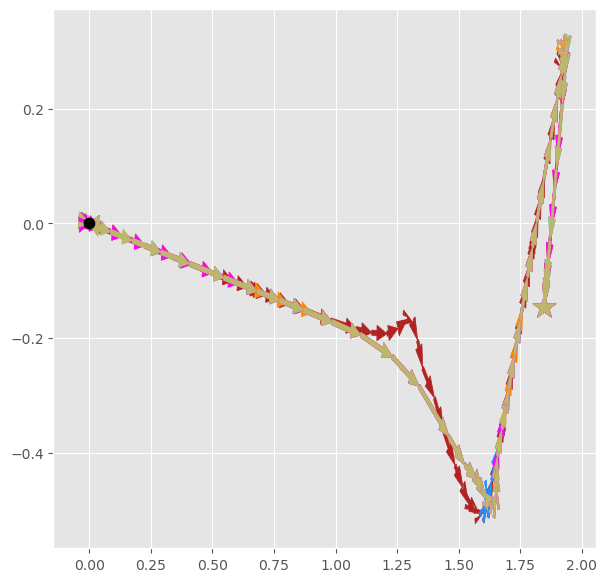

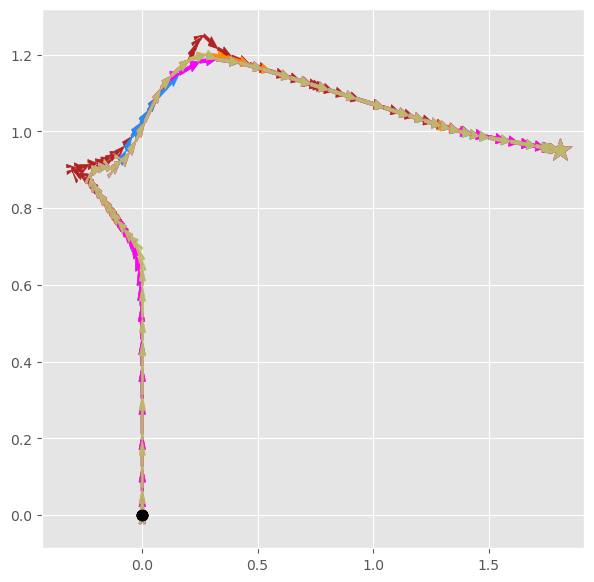

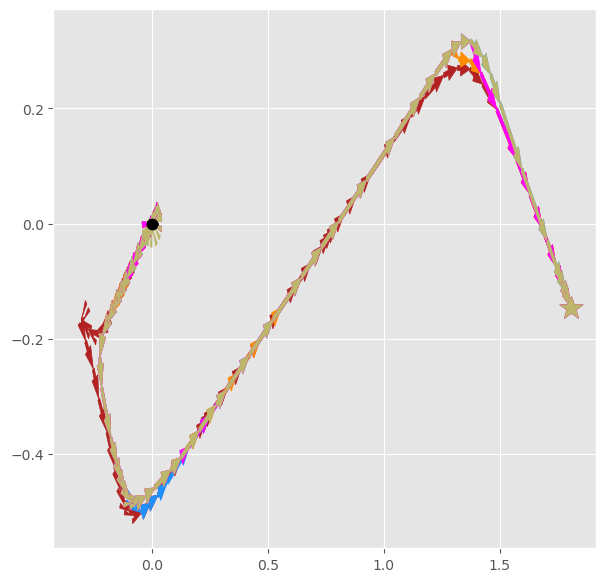

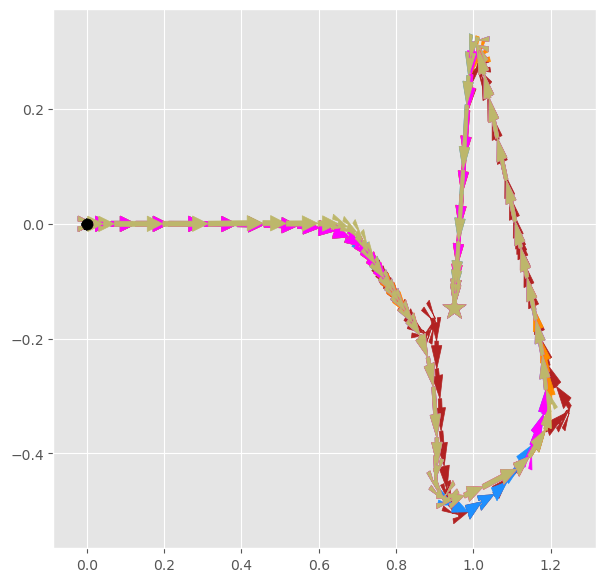

In [52]:
plot_outputs(SC, [ref_path, path, paths[-1], path_k1, path_k2], figsize=(7,7), plot_save="comp_paths")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


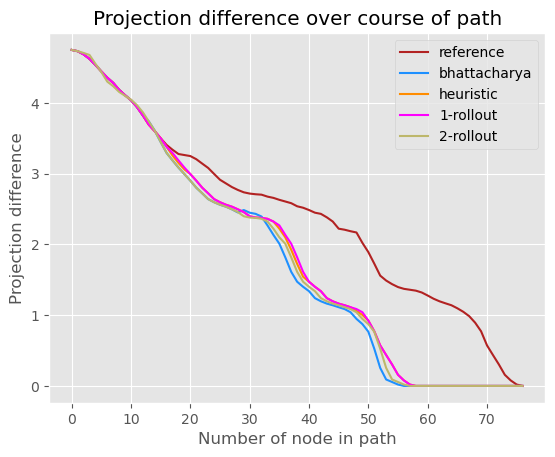

In [54]:
def plot_proj_diff_over_time(paths, ref_proj, colors=['firebrick', 'dodgerblue', 'darkorange', 'fuchsia', 'darkkhaki', 'aqua'], fname="prof_diff_over_time", labels=None):
    max_len = np.max(np.array([len(path.nodes) for path in paths]))
    num_paths = len(paths)
    path_proj_diffs = np.zeros((num_paths, max_len))
    time = np.arange(max_len)

    plt.figure()
    for i, path in enumerate(paths):
        path_len = len(path.nodes)
        path_projs = path.edge_projections
        path_proj_diff = np.linalg.norm(path_projs - ref_proj, ord=1, axis=1)
        path_proj_diffs[i,:path_len] = path_proj_diff
        path_proj_diffs[i,path_len:] = path_proj_diff[-1]
        plt.plot(time, path_proj_diffs[i] , color=colors[i%len(colors)])    
    plt.xlabel("Number of node in path")
    plt.ylabel("Projection difference")
    plt.title("Projection difference over course of path")
    if labels is not None:
        plt.legend(labels)
    plt.savefig(fname + '.eps', format='eps')
    plt.show()
    return path_proj_diffs

x = plot_proj_diff_over_time([ref_path, path, paths[-1], path_k1, path_k2], ref_proj, fname="compare_w_bhattacharya", labels=['reference', 'bhattacharya', 'heuristic', '1-rollout', '2-rollout'])


In [56]:
print(ref_path.path_length[-1], path.path_length[-1], paths[-1].path_length[-1], path_k1.path_length[-1], path_k2.path_length[-1])

8.000000000000007 6.417953973523912 6.715683144549827 6.541277434076944 6.479615703800428


In [ ]:
ref_proj = ref_path.edge_projections[-1]
#path3, _, _ = k_rollout(SC, ref_path, 2, 1)
#path4, _, _ = k_rollout(SC, ref_path, 2, 2)
#path0 ,_,_,_,_ = augmented_dijkstra(SC, start, end, ref_proj, 0, False, 0)
#path1 ,_,_,_,_ = augmented_dijkstra(SC, start, end, ref_proj, 1, False, 0)
#path2 ,_,_,_,_ = augmented_dijkstra(SC, start, end, ref_proj, 2, False, 0)

In [ ]:
dijkstra_tree(SC, path4, [path3], ref_class, plot_others=True)

In [ ]:
print(path0.path_length[-1], path1.path_length[-1], path2.path_length[-1], path3.path_length[-1], path4.path_length[-1])

# Results (Varying k)

In [ ]:
ref_proj = ref_path.edge_projections[-1]
#alpha = 2
path3, _, _ = k_rollout(SC, ref_path, 2, 1)
path4, _, _ = k_rollout(SC, ref_path, 2, 2)
path0 ,_,_,_,_ = augmented_dijkstra(SC, start, end, ref_proj, 0, False, 0)
path1 ,_,_,_,_ = augmented_dijkstra(SC, start, end, ref_proj, 1, False, 0)
path2 ,_,_,_,_ = augmented_dijkstra(SC, start, end, ref_proj, 2, False, 0)
dijkstra_tree(SC, path4, [path3], ref_class, plot_others=True)

# Results (Comparing with Bhattacharya)

In [ ]:
n_side, point_gen_mode = 20, 0

r1, r2 = 0.6, 0.3
n_holes = 2
angle = 2 * np.pi / n_holes
phase = np.pi/4
hole_locs = np.array([(r1 * np.cos(angle * i + phase), r1 * np.sin(angle * i + phase)) for i in range(n_holes)])

# Initialize Simplicial Complex (SC)
pts = generate_pts(point_gen_mode, n_side)
SC = SimplicialComplex(pts, True)
n_side, point_gen_mode = 20, 0
start, end = 0, len(SC.node_vec)-1

all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.make_holes(hole_locs, r2)

In [ ]:
coords = np.array([(-1,-1), (-1,0), (0,0), (0,-1), (-1, -1), (-1,0), (1,0), (1,1)])
ref_path, ref_path_class, path_proj, _ = path_from_coords(SC, coords, 'red', True)
start, end = ref_path.nodes[0], ref_path.nodes[-1]
ref_class = Trajectory_Class(SC, False)
ref_class.add_path(ref_path)

In [ ]:
zeros = make_analytical_func(2, 2)
poles = r2complex(hole_locs)
proj_dict = make_proj_dict(SC, zeros, poles)

In [ ]:
start, end = ref_path.nodes[0], ref_path.nodes[-1]
path, other_paths = bhattacharya(SC, ref_path, start, end, proj_dict, others=True)
shortest_in_ref = Trajectory(SC, path, 0)
other_paths = [Trajectory(SC, path) for path in other_paths]
dijkstra_tree(SC, shortest_in_ref, other_paths, ref_class, plot_others=True)

In [ ]:
alpha = 2
path0 ,_,_,_,_ = augmented_dijkstra(SC, start, end, ref_path.edge_projections[-1], 0, False, 0)
path1 ,_,_,_,_ = augmented_dijkstra(SC, start, end, ref_path.edge_projections[-1], alpha, False, 0)
path3, _, _ = k_rollout(SC, ref_path, 2, 1)
dijkstra_tree(SC, path3, [path0, path1], ref_class, plot_others=True)

In [ ]:
dijkstra_tree(SC, path3, [path0, path1], ref_class, plot_others=True)

In [ ]:
n_side, point_gen_mode = 20, 0

r1, r2 = 0.6, 0.3
n_holes = 2
angle = 2 * np.pi / n_holes
phase = -np.pi/4
hole_locs = np.array([(r1 * np.cos(angle * i + phase), r1 * np.sin(angle * i + phase)) for i in range(n_holes)])

# Initialize Simplicial Complex (SC)
pts = generate_pts(point_gen_mode, n_side)
SC = SimplicialComplex(pts, True)
n_side, point_gen_mode = 20, 0
start, end = 0, len(SC.node_vec)-1

all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.make_holes(hole_locs, r2)

coords = np.array([(-1,-1), (1, -1), (1, 0), (0,0), (0,-1), (1,-1), (1,0), (-1, 0), (-1, 1), (1,1)])
ref_path, ref_path_class, path_proj, _ = path_from_coords(SC, coords, 'red', False)
coords2 = np.array([(-1,-1), (-1, 1), (0, 1), (0, -1), (1, -1), (1,1)])
path, path_class, path_proj, _ = path_from_coords(SC, [(-1,-1), (-1, 1), (1,1)], 'green', False)
path2, path_class2, path_proj2, _ = path_from_coords(SC, coords2, 'blue', False)

zeros = make_analytical_func(2, 2)
poles = r2complex(hole_locs)
proj_dict = make_proj_dict(SC, zeros, poles)
path, other_paths = bhattacharya(SC, ref_path, start, end, proj_dict, others=True)

In [ ]:
traj1 = Trajectory(SC, path, 0)
other_traj = [Trajectory(SC, path) for path in other_paths]
dijkstra_tree(SC, traj1, other_traj, ref_path_class, plot_others=True)

In [ ]:
alpha = 2
path0 ,_,_,_,_ = augmented_dijkstra(SC, start, end, ref_path.edge_projections[-1], 0, False, 0)
path1 ,_,_,_,_ = augmented_dijkstra(SC, start, end, ref_path.edge_projections[-1], alpha, False, 0)
path3, _, _ = k_rollout(SC, ref_path, alpha, 1)
dijkstra_tree(SC, path3, [path0, path1], ref_class, plot_others=True)

In [ ]:
def plot_bases(SC, extra, font, figsize=(5,5), arrowmult=7, node_size=5):
    node_pos = {i:SC.nodes[i] for i in (np.where(SC.node_vec == 1)[0])}
    num_bases = SC.H_extra.shape[0] if extra else SC.H.shape[0]
    for i in range(num_bases):
        harm_vec = SC.H_extra[i,:]
        harm_vec_sign = np.sign(harm_vec)
        harm_vec_weight = np.abs(harm_vec)
        GG = nx.DiGraph()
        G_oriented = nx.DiGraph()
        j = 0
        for k, edge in enumerate(SC.edges):
            if not SC.edge_vec[k]:
                continue
            sign, weight = harm_vec_sign[j], harm_vec_weight[j] * 10
            oriented_edge = (edge[0], edge[1]) if (sign > 0) else (edge[1], edge[0])
            G_oriented.add_edge(oriented_edge[0], oriented_edge[1], weight=weight)
            GG.add_edge(edge[0], edge[1], weight=weight)
            j += 1

        oriented_weights = [G_oriented[u][v]['weight'] for u,v in G_oriented.edges]
        plt.figure(figsize=figsize)
        nx.draw(G_oriented, pos=node_pos, node_size=node_size, node_color='gray', width=oriented_weights, edge_color='black', arrows=True, arrowstyle='-|>', arrowsize=[arrowmult * i for i in oriented_weights])
        plt.title(f"Harmonic Basis Vector $h_{i+1}$", fontdict=font)
        plt.show()

arrowmult, nodesize = 7, 3
plot_bases(SC, False, font, (5,5), arrowmult, nodesize)

In [ ]:
Gprime = nx.Graph()

for i, edge in enumerate(SC.graph.edges):
    if SC.edge_vec[i]:
        u, v = edge
        Gprime.add_egde(u, v, weight=0, idx=i)

# for i, edge in enumerate(self.edges):
#     if self.edge_vec[i]:
#         u, v = edge
#         w = np.linalg.norm(self.nodes[u] - self.nodes[v]) if weighted else 1
#         G.add_edge(u, v, weight=w, idx=i)
        

SC.graph = Gprime
path,_,_,_,_ = augmented_dijkstra(SC, start, end, ref_path.edge_projections[-1], 0, False, 0)

